Kristupas Norvaiša

Imports

In [1]:
!pip install fiftyone tensorflow torch torchvision umap-learn 'ipywidgets>=7.5,<8'

from datetime import datetime
from google.colab import drive
import math
import os
import shutil
from PIL import Image
import torch
import torchvision.transforms as transforms
import fiftyone as fo
import fiftyone.zoo as foz
import matplotlib.pyplot as plt
import numpy as np
import re

data_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.9/492.9 k

INFO:fiftyone.migrations.runner:Migrating database to v0.20.1


Datasets from fiftyone

In [3]:
t_dir = "/content/drive/MyDrive/deep_learning/deep_learning/train"
v_dir = "/content/drive/MyDrive/deep_learning/deep_learning/valid"

t_data = foz.load_zoo_dataset("open-images-v6", split="train", label_types=["segmentations", "classifications"], classes = ["Cat", "Dog", "Car"], max_samples=70, shuffle = True)
v_data = foz.load_zoo_dataset("open-images-v6", split="validation", label_types=["segmentations", "classifications"], classes = ["Cat", "Dog", "Car"], max_samples=70, shuffle = True)

drive.mount('/content/drive')

os.makedirs(os.path.join(t_dir, "images"), exist_ok=True)
os.makedirs(os.path.join(t_dir, "masks"), exist_ok=True)
os.makedirs(os.path.join(v_dir, "images"), exist_ok=True)
os.makedirs(os.path.join(v_dir, "masks"), exist_ok=True)


INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/root/fiftyone/open-images-v6/train' if necessary


Necessary images already downloaded


INFO:fiftyone.utils.openimages:Necessary images already downloaded


Existing download of split 'train' is sufficient


INFO:fiftyone.zoo.datasets:Existing download of split 'train' is sufficient


Loading existing dataset 'open-images-v6-train-70'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Loading existing dataset 'open-images-v6-train-70'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Downloading split 'validation' to '/root/fiftyone/open-images-v6/validation' if necessary


Necessary images already downloaded


INFO:fiftyone.utils.openimages:Necessary images already downloaded


Existing download of split 'validation' is sufficient


INFO:fiftyone.zoo.datasets:Existing download of split 'validation' is sufficient


Loading existing dataset 'open-images-v6-validation-70'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Loading existing dataset 'open-images-v6-validation-70'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


Mounted at /content/drive


Save images and masks to google drive

In [4]:
import os
import shutil

def prep_dataset(ds, split, root):
    mask_files = []
    for d, _, f in os.walk(f"/root/fiftyone/open-images-v6/{split}/labels/masks"):
        for file in f:
            if file.endswith(".png"):
                mask_files.append(os.path.join(d, file))
    for sample in ds:
        fname = os.path.basename(sample.filepath)
        shutil.move(sample.filepath, os.path.join(os.path.join(root, "images"), fname))
        mask_file = next((f for f in mask_files if os.path.splitext(fname)[0] in f), None)
        if mask_file:
            shutil.move(mask_file, os.path.join(os.path.join(root, "masks"), os.path.splitext(fname)[0] + ".png"))

prep_dataset(t_data, 'train', t_dir)
prep_dataset(v_data, 'validation', v_dir)




Dataset

In [5]:
class BackgroundDataset(torch.utils.data.Dataset):
    def __init__(self, main_dir, train = False):
        self.train = train
        self.pic_dir = os.path.join(main_dir, 'images')
        self.mask_dir = os.path.join(main_dir, 'masks')
 
        self.pic_list = [fn for fn in os.listdir(self.pic_dir) if fn.endswith('.jpg')]
        self.mask_list = [fn for fn in os.listdir(self.mask_dir) if fn.endswith('.png')]
        
        self.pic_list.sort()
        self.mask_list.sort()
 
    def __len__(self):
        return len(self.pic_list)
 
    def modify(self, img, mask):
        mask_name = mask.filename
        img = img.resize((256, 256)) 
        mask = mask.resize((256, 256))  
        if self.train:
            pad = lambda x : math.ceil(max(0, 256 - x) / 2)
            img, mask = [transforms.functional.pad(i, [pad(i.width), pad(i.height)]) for i in [img, mask]]
            params = transforms.RandomCrop.get_params(img, output_size = (256, 256))
            img, mask = [transforms.functional.crop(i, *params) for i in [img, mask]]
        else:
            pad = lambda x : math.ceil(x / 8) * 8 - x
            img, mask = [transforms.functional.pad(i, [0, 0, pad(i.width), pad(i.height)]) for i in [img, mask]]

        img = transforms.functional.normalize(transforms.functional.to_tensor(img), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        mask = transforms.functional.to_tensor(mask)

        for label, v in [('m096mb', 3.0), ('m0bt9lr', 2.0), ('m01yrx', 1.0)]:
          if label in mask_name:
            mask[mask > 0] = v
          
        mask[mask > 0] = 0.0
        return img, mask
 
    def __getitem__(self, idx):
        pic_name = os.path.join(self.pic_dir, self.pic_list[idx])
        mask_name = os.path.join(self.mask_dir, self.mask_list[idx])
 
        img = Image.open(pic_name)
        mask = Image.open(mask_name)
 
        return self.modify(img.convert('RGB'), mask)


In [6]:
def seconds_to_time(seconds):
    s = int(seconds) % 60
    m = int(seconds) // 60
    if m < 1:
        return f'{s}s'
    h = m // 60
    m = m % 60
    if h < 1:
        return f'{m}m{s}s'
    return f'{h}h{m}m{s}s'

In [7]:
def train_epoch(optim, loss_func, mdl, ldr):
  mdl.train()
  loss_accum = np.array([], dtype = np.float32)

  for d in ldr:
    img = d[0].to(data_device)
    msk = d[1].to(data_device)
    msk = msk.squeeze(1)
    msk = msk.long().to(data_device)

    predictions = mdl(img)

    num_cls = 4

    one_hot_msk = torch.nn.functional.one_hot(msk, num_classes=num_cls).permute(0, 3, 1, 2).float()
    
    lss = loss_func(predictions, one_hot_msk)
    loss_accum = np.append(loss_accum, lss.cpu().detach().numpy())

    lss.backward()
    optim.step()
    optim.zero_grad()

  return np.mean(loss_accum)


In [8]:
def evaluate(mdl, ldr):
  mdl.eval()

  tot_iou = 0.0
  tot_pred = 0
  tot_dice = 0.0
  tot_f1 = 0.0
  tot_int = 0.0
  tot_uni = 0.0
  
  for d in ldr:
    img = d[0].to(data_device)
    msk = d[1]
    msk = msk.squeeze(1)
    msk = msk.numpy()

    with torch.no_grad():
      pred = mdl(img)

    pred = torch.argmax(pred, dim=1)
    pred = pred.cpu().detach().numpy()
    
    int = 0.0
    uni = 0.0
    for i in range(len(msk)):
      msk_nz = msk[i].max()
      int += ((pred[i] == msk[i]) & (msk_nz == pred[i])).sum()
      uni += ((msk_nz == msk[i]) | (msk_nz == pred[i])).sum()
        
    if uni != 0:
      iou = int / uni
      dice = 2 * int / (pred[0].size + msk[0].size)
      f1 = int / (int + 0.5 * uni)
    elif uni == 0.0 and int == 0.0:
      iou = 0.0
      dice = 0.0
      f1 = 0.0
    
    tot_iou += iou
    tot_dice += dice
    tot_f1 += f1
    tot_pred += 1
    tot_int += int
    tot_uni += uni

  if tot_pred != 0:
    mean_iou = tot_iou / tot_pred
    mean_dice = tot_dice / tot_pred
    micro_f1 = tot_f1 / 3
    macro_f1 = tot_int / (tot_int + 0.5 * tot_uni)
  else:
    mean_iou = 0.0
    mean_dice = 0.0
    micro_f1 = 0.0
    macro_f1 = 0.0

  return mean_iou, mean_dice, micro_f1, macro_f1


In [9]:
def train_and_eval(mdl, ldr_train, ldr_valid, e_count = 10, lr = 1e-3):
  l_func = torch.nn.BCEWithLogitsLoss()
  optim = torch.optim.Adam(mdl.parameters(), lr = lr)

  s_time = datetime.now()

  t_iou_acum = []
  v_iou_acum = []
  dice_acum = []
  m_f1_acum = []
  ma_f1_acum = []
  for e in range(e_count):
    lss = train_epoch(optim, l_func, mdl, ldr_train)
    t_iou, _, _, _ = evaluate(mdl, ldr_train)
    t_iou_acum.append(t_iou)
    v_iou, dice, m_f1, ma_f1 = evaluate(mdl, ldr_valid)

    v_iou_acum.append(v_iou)
    dice_acum.append(dice)
    m_f1_acum.append(m_f1)
    ma_f1_acum.append(ma_f1)

    c_time = datetime.now()
    elpsd = seconds_to_time((c_time - s_time).total_seconds())
    print(f'Epoch: {e}, Time: {elpsd}, Training loss: {lss}')
    print(f'  Training IoU: {np.round(t_iou * 100)}, Validation IoU: {np.round(v_iou * 100)}')

  return t_iou_acum, v_iou_acum, dice_acum, m_f1_acum, ma_f1_acum

In [10]:
def plot_iou(train_iou, valid_iou):
  plt.clf()
  plt.plot(train_iou, 'b', label = 'Training IoU')
  plt.plot(valid_iou, 'r', label = 'Validation IoU')
  plt.ylim(0.0, 1.0)
  plt.legend()
  plt.show()

Network

In [12]:
class FCNNet(torch.nn.Module):
  def __init__(self, in_channels):
    super().__init__()
    
    self.conv1_1 = torch.nn.Conv2d(in_channels, 16, (3, 3), padding = 'same')
    self.relu1_1 = torch.nn.ReLU()
    self.conv1_2 = torch.nn.Conv2d(16, 16, (3, 3), padding = 'same')
    self.relu1_2 = torch.nn.ReLU()
    
    self.pool2 = torch.nn.MaxPool2d((2, 2), (2, 2))
    self.conv2_1 = torch.nn.Conv2d(16, 32, (3, 3), padding = 'same')
    self.relu2_1 = torch.nn.ReLU()
    self.conv2_2 = torch.nn.Conv2d(32, 32, (3, 3), padding = 'same')
    self.relu2_2 = torch.nn.ReLU()
    
    self.pool3 = torch.nn.MaxPool2d((2, 2), (2, 2))
    self.conv3_1 = torch.nn.Conv2d(32, 64, (3, 3), padding = 'same')
    self.relu3_1 = torch.nn.ReLU()
    self.conv3_2 = torch.nn.Conv2d(64, 64, (3, 3), padding = 'same')
    self.relu3_2 = torch.nn.ReLU()
    
    self.pool4 = torch.nn.MaxPool2d((2, 2), (2, 2))
    self.conv4_1 = torch.nn.Conv2d(64, 128, (3, 3), padding = 'same')
    self.relu4_1 = torch.nn.ReLU()
    self.conv4_2 = torch.nn.Conv2d(128, 128, (3, 3), padding = 'same')
    self.relu4_2 = torch.nn.ReLU()
    self.conv4_3 = torch.nn.Conv2d(128, 64, (3, 3), padding = 'same')
    self.relu4_3 = torch.nn.ReLU()
    self.upscale4 = torch.nn.Upsample(scale_factor = 2)
    
    self.conv5_1 = torch.nn.Conv2d(64, 64, (3, 3), padding = 'same')
    self.relu5_1 = torch.nn.ReLU()
    self.conv5_2 = torch.nn.Conv2d(64, 32, (3, 3), padding = 'same')
    self.relu5_2 = torch.nn.ReLU()
    self.upscale5 = torch.nn.Upsample(scale_factor = 2)
    
    self.conv6_1 = torch.nn.Conv2d(32, 32, (3, 3), padding = 'same')
    self.relu6_1 = torch.nn.ReLU()
    self.conv6_2 = torch.nn.Conv2d(32, 16, (3, 3), padding = 'same')
    self.relu6_2 = torch.nn.ReLU()
    self.upscale6 = torch.nn.Upsample(scale_factor = 2)
    
    self.conv7_1 = torch.nn.Conv2d(16, 16, (3, 3), padding = 'same')
    self.relu7_1 = torch.nn.ReLU()
    self.conv7_2 = torch.nn.Conv2d(16, 16, (3, 3), padding = 'same')
    self.relu7_2 = torch.nn.ReLU()
    
    self.conv8 = torch.nn.Conv2d(16, 4, (1, 1))
    self.softmax8 = torch.nn.Softmax(dim=1)

  def forward(self, x):
    block1 = torch.nn.Sequential(
        self.conv1_1,
        self.relu1_1,
        self.conv1_2,
        self.relu1_2
    )(x)
    block2 = torch.nn.Sequential(
        self.pool2,
        self.conv2_1,
        self.relu2_1,
        self.conv2_2,
        self.relu2_2,
    )(block1)
    block3 = torch.nn.Sequential(
        self.pool3,
        self.conv3_1,
        self.relu3_1,
        self.conv3_2,
        self.relu3_2,
    )(block2)
    block4 = torch.nn.Sequential(
        self.pool4,
        self.conv4_1,
        self.relu4_1,
        self.conv4_2,
        self.relu4_2,
        self.conv4_3,
        self.relu4_3,
        self.upscale4,
    )(block3) + block3
    block5 = torch.nn.Sequential(
        self.conv5_1,
        self.relu5_1,
        self.conv5_2,
        self.relu5_2,
        self.upscale5,
    )(block4) + block2
    block6 = torch.nn.Sequential(
        self.conv6_1,
        self.relu6_1,
        self.conv6_2,
        self.relu6_2,
        self.upscale6,
    )(block5) + block1
    block7 = torch.nn.Sequential(
        self.conv7_1,
        self.relu7_1,
        self.conv7_2,
        self.relu7_2,
    )(block6)
    block8 = torch.nn.Sequential(
        self.conv8,
        self.softmax8
    )(block7)
    return block8

Data

In [13]:
train_dataset = BackgroundDataset('/content/drive/MyDrive/deep_learning/deep_learning/train', train = True)
valid_dataset = BackgroundDataset('/content/drive/MyDrive/deep_learning/deep_learning/valid', train = False)

num_workers = 2
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = 1, num_workers = num_workers, shuffle = False)

print(f'Train: {len(train_dataset)}, Test: {len(valid_dataset)}')

Train: 350, Test: 369


Training and testing

Parameter count: 441,284
Epoch: 0, Time: 2m1s, Training loss: 0.6946395039558411
  Training IoU: 100.0, Validation IoU: 100.0
Epoch: 1, Time: 2m38s, Training loss: 0.5981760025024414
  Training IoU: 100.0, Validation IoU: 100.0
Epoch: 2, Time: 3m17s, Training loss: 0.5981760025024414
  Training IoU: 100.0, Validation IoU: 100.0
Epoch: 3, Time: 3m58s, Training loss: 0.5981760025024414
  Training IoU: 100.0, Validation IoU: 100.0
Epoch: 4, Time: 4m35s, Training loss: 0.5981760025024414
  Training IoU: 100.0, Validation IoU: 100.0


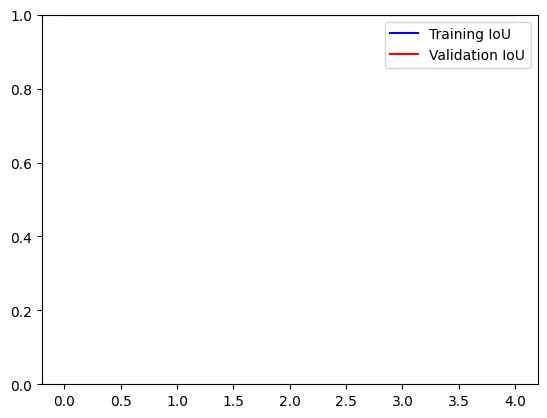

Dice score: 1.0
Micro_F1 score: 81.99999999999956
Macro_f1 score: 0.6666666666666666


In [14]:
model = FCNNet(train_dataset[0][0].shape[0]).to(data_device)
print(f'Parameter count: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

train_iou, valid_iou, dice, micro_f1, macro_f1 = train_and_eval(model, train_loader, valid_loader, e_count = 5, lr = 1e-3)
plot_iou(train_iou, valid_iou)

print(f"Dice score: {sum(dice)/len(dice)}")
print(f"Micro_F1 score: {sum(micro_f1)/len(micro_f1)}")
print(f"Macro_f1 score: {sum(macro_f1)/len(macro_f1)}")
